# Week 3 - Single Qubit Gates
We work with a tuneable transmon. 

In [33]:
import numpy as np
import matplotlib.pyplot as plt


In [34]:
# Constants and cutoffs
n_cutoff = 15
e        = 1

# Hamiltonian parameters (from fabrication)
EC       = 1
EJ       = 50       # This is EJ1
gamma    = 2.5      # EJ2 = gamma * EJ1

In [35]:
from scipy.sparse import diags, csr_matrix
# Q matrix. Diagonal in the charge basis
def create_q_matrix(n_cutoff = n_cutoff, e = e):
    diagonal    = np.arange(-n_cutoff, n_cutoff + 1, 1)
    q_matrix    = diags(diagonal)
    return 2 * e * q_matrix

# Creates exp^{i \Phi / \Phi_0}
def create_exp_flux(cyclic = True, n_cutoff = n_cutoff):
    n = n_cutoff * 2 + 1
    off_diag = np.ones(n - 1)
    off_diag_sparse = diags(off_diag, offsets = 1)
    cos_matrix = off_diag_sparse

    if cyclic:
        cyclic_component = csr_matrix(([1], ([n-1], [0])), shape = (n, n))
    
    return (cos_matrix + cyclic_component)

# Create cos(\Phi/\Phi_0) = exp(x) + exp(-x)
def create_cos_matrix(cyclic = True, n_cutoff = n_cutoff):
    exp_flux    = create_exp_flux(cyclic = cyclic, n_cutoff = n_cutoff)
    cos_matrix  = (exp_flux + exp_flux.getH()) / 2
    return cos_matrix
    



In [36]:
def V(EC = EC, n_cutoff = n_cutoff, charge_offset = 0):
    charge_term = 4 * EC * (np.arange(-n_cutoff, n_cutoff + 1, 1) - charge_offset * 2 * e) ** 2
    return charge_term

def create_Hamilton(charge_offset = 0, external_flux = 0, EC = EC, EJ = EJ, gamma = gamma, n_cutoff = n_cutoff, cyclic = True):
    # Compute the first term including charge and a possible offset
    charge_term = 4 * EC * (create_q_matrix(n_cutoff) - charge_offset * 2 * e) ** 2 + 0j
    
    # Compute the Josephson Junction Energy
    EJ_sum      = EJ + gamma * EJ
    d = (gamma - 1) / (gamma + 1)

    external_flux_factor = np.cos(external_flux) ** 2 + d ** 2 * np.sin(external_flux) ** 2
    cosine               = create_cos_matrix(cyclic = cyclic, n_cutoff = n_cutoff)

    return (charge_term - EJ_sum * external_flux_factor * cosine).astype(np.complex64)

In [37]:
from scipy.sparse.linalg import eigsh 
def get_eigen(matrix, n_states):
    eigenvalues, eigenvectors = eigsh(matrix, k = n_states, which = "SA")
    return eigenvalues, eigenvectors

charges    = np.arange(-n_cutoff, n_cutoff + 1, 1)
potential  = V()

H = create_Hamilton()
es, psis = get_eigen(H, n_states = 3)
    


I'm probably not plotting the right things here.

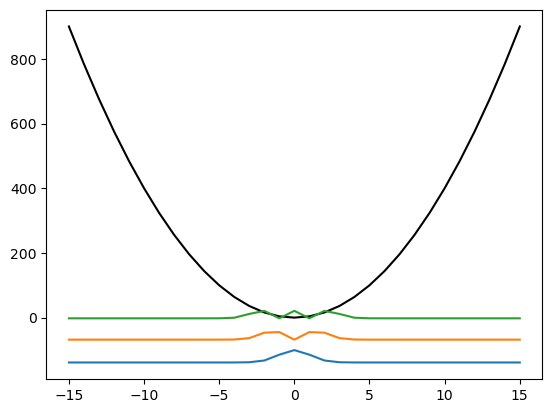

In [38]:
plt.plot(charges, potential, "k-")
plt.plot(charges, 100 * abs(psis[:, 0]) ** 2 + es[0])
plt.plot(charges, 100 * abs(psis[:, 1]) ** 2 + es[1])
plt.plot(charges, 100 * abs(psis[:, 2]) ** 2 + es[2])

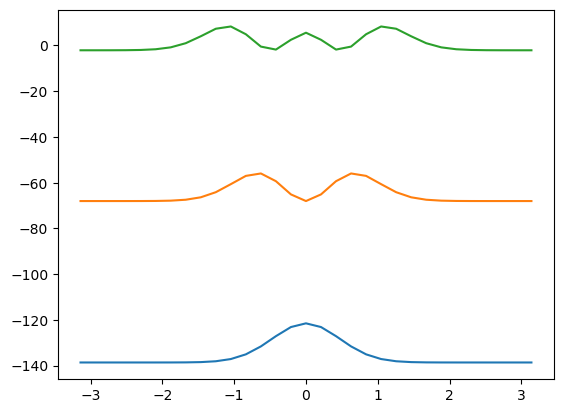

In [39]:
def get_fourier_transform_matrix(n_cutoff = n_cutoff):
    n       = n_cutoff * 2 + 1
    qs      = np.arange(-n_cutoff, n_cutoff + 1, 1)
    phis    = np.linspace(- np.pi, np.pi, n)

    return 1 / np.sqrt(n) * np.exp(1j * np.outer(qs, phis))
    
T = get_fourier_transform_matrix()

fluxes = np.linspace(-np.pi, np.pi, 2 * n_cutoff + 1)

# plt.plot(charges, potential, "k-")
plt.plot(fluxes, 100 * abs(psis[:, 0] @ T ) ** 2 + es[0])
plt.plot(fluxes, 100 * abs(psis[:, 1] @ T ) ** 2 + es[1])
plt.plot(fluxes, 100 * abs(psis[:, 2] @ T ) ** 2 + es[2])


## Exercise 3 

Here we try to make gates. First step is to go the three dimensional space using the eigenstates, we found above.

In [40]:
# Normalize to omegea = 1
omega_0 = es[0]
omega   = es[1] - es[0]

# Define hamiltonian for charge H0
H_Q = np.diag(es - omega_0) 
H_Q 

array([[  0.     ,   0.     ,   0.     ],
       [  0.     ,  70.58202,   0.     ],
       [  0.     ,   0.     , 136.50516]], dtype=float32)

Define a drive hamiltonian.

In [41]:
# Create charge matrix:
H_C = np.matrix(psis).H @ create_q_matrix() / 2  / e @ psis


# Normalize according to omega
# H_C /= omega



In [42]:
abs(H_C)

matrix([[2.09333067e-06, 1.04986898e+00, 5.48806804e-06],
        [1.04986898e+00, 2.30739753e-06, 1.43411332e+00],
        [5.48806804e-06, 1.43411332e+00, 2.52464060e-07]])

In [43]:
from scipy.stats import norm
def create_gaussian_envelope(Theta = np.pi, T = 0, sigma = 1):
    def s(t):
        return Theta * norm.pdf(t, loc = T, scale = sigma)
    return s


In [44]:
def H_with_pulse(Theta = np.pi, T = 0, sigma = 1, offset_phase = 0):
    A   = 1 / (2 * abs(H_C[0, 1]))
    s   = create_gaussian_envelope(Theta = Theta, T = T, sigma = sigma)
    def H(t):
        return H_Q + A * s(t) * np.cos(omega * t + offset_phase) * H_C
    def pulse(t):
        return A * s(t) * np.cos(t + offset_phase)
        
    return H, pulse
   

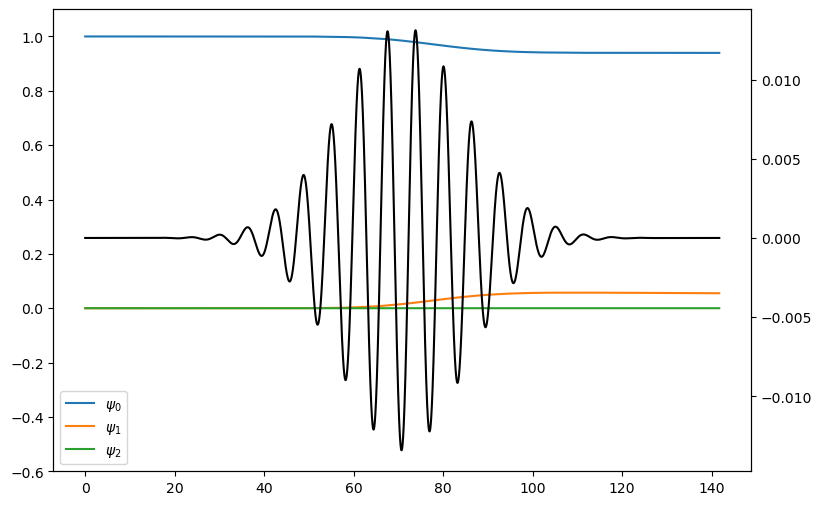

In [45]:
from scipy.integrate import solve_ivp
psi0 = np.array([1, 0, 0], dtype = np.complex64)
dt   = 1 / omega
time = (0, dt * 10000)

H, pulse    = H_with_pulse(Theta = 1, T = dt * 5000, sigma = 1000 * dt, offset_phase = np.pi / 2)

def diff_equation(t, y):
     H_of_t = H(t)
     dy     = - 1j * H_of_t @ y.T
     return dy

results = solve_ivp(diff_equation, t_span = time, y0 = psi0, method = "RK45")

fig, ax = plt.subplots(figsize = (9, 6))
ax.plot(results.t, abs(results.y[0,:])**2, label = "$\psi_0$")
ax.plot(results.t, abs(results.y[1,:])**2, label = "$\psi_1$")
ax.plot(results.t, abs(results.y[2,:])**2, label = "$\psi_2$")
ax.set_ylim(-0.6, 1.1)

ax1 = ax.twinx()
ax1.plot(results.t, pulse(results.t), "k", label = "pulse")
# ax1.set_ylim(-3, 15)
ax.legend()